# Explaining `DistilBERT` with integrated gradients

<a href="https://colab.research.google.com/drive/1Q-Tk27YFR3N5elO9XJvdfrhAUWqzBL3M" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).

BERT ([Bidirectional Encoder Representations from Transformers](https://paperswithcode.com/method/bert)) models have gained significant prominence in natural language processing tasks due to their ability to capture context and relationships within language. However, the complexity of these models poses challenges in terms of interpretability.

The intricate architecture of BERT, with its multiple layers and attention mechanisms, makes it difficult for humans to comprehend the decision-making process behind its predictions. Hence, XAI researchers (EXplaineble AI) strive to bridge this gap by offering techniques to make BERT models more transparent and interpretable.

XAI techniques, when applied to BERT models, can involve things like:

- Visualizing attention maps to highlight important words or phrases.
- Extracting relevant features that contribute to predictions.

<img src="https://production-media.paperswithcode.com/methods/new_BERT_Overall.jpg" alt="bert-model" width="800"/>

[Source](https://arxiv.org/abs/1810.04805v2).

In this tutorial, we will try to understand the outputs of a BERT model by using a technique called [`integrated Gradients`](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients). This method allows us to get some insight into the inner workings of models via an empirical analysis (input $x$ generates output $y$), using its gradient to determine what **influences** the individual parts of an input (**like words in a sentence or pixels in an image**) have on the output of a model.

> **Note: This method was proposed in Sundararajan et al., in "_[Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)_". To learn more about it, check out other tutorials [[1](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Explainability/NLP/integrated_gradients_in%20_keras_nlp.ipynb)] [[2](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/interpretability/integrated_gradients.ipynb)].**

The object of our explainability analysis will be the [DistilBERT model we created in this tutorial](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Explainability/NLP/model_maker.ipynb). Hence, let us downloaded from the Hub! 🤗

In [35]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from transformers import TextClassificationPipeline

# Load the model and tokenizer
model = TFAutoModelForSequenceClassification.from_pretrained("AiresPucrs/distilbert-base-cased-sentiment-classifier")
tokenizer = AutoTokenizer.from_pretrained("AiresPucrs/distilbert-base-cased-sentiment-classifier")

# Create a text classification pipeline
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

# Classify some samples
texts = [
    'Is to complicated and boring.',
    'Is nice to see philosophers doing machine learning.',
  ]

for text in texts:
  preds = pipeline(text)

  print(f"""\nReview: '{text}'\n(Label: {preds[0]['label']} | Confidence: {preds[0]['score'] * 100:.2f}%)""")


Review: 'Is to complicated and boring.'
(Label: NEGATIVE | Confidence: 94.99%)

Review: 'Is nice to see philosophers doing machine learning.'
(Label: POSITIVE | Confidence: 99.69%)


You can also do classifications by passing inputs straight to the model and processing the **logits** yourself. **Logits** provide the raw scores or predictions from a model. At the same time, the **softmax** function is applied to these logits to convert them into probabilities, making it easier to interpret the model's confidence in each class.

In [57]:
import tensorflow as tf

text = "This was a masterpiece. Not completely faithful to the books, \
but enthralling from beginning to end. Might be my favorite of the three."

inputs = tokenizer(text, return_tensors="tf")

# Pass it through the model and get the logits
logits = model(**inputs).logits
print("Logits: ", logits)

# Get the index of the maximum argument (the class)
prediction = tf.math.argmax(logits, axis=-1)
print("Class: ", model.config.id2label[int(prediction)])

# Get the logit value after softmax (the confidence)
softmax_output = tf.nn.softmax(logits).numpy()[0][int(prediction)]
print("Confidence: ", softmax_output)


Logits:  tf.Tensor([[-3.9134598  3.0466256]], shape=(1, 2), dtype=float32)
Class:  POSITIVE
Confidence:  0.99905187


Now, let us try to understand these results.

The `integrated gradients` is a powerful technique for computing feature attributions within a deep learning model. This approach leverages the gradient of the model's output (prediction) concerning the input features, providing a comprehensive understanding of the contribution of each feature. Notably, integrated gradients apply to a broad range of deep learning models, encompassing NLP, CV, and models that work with tabular data.

In the context of a text classification model, the method proves invaluable for interpreting predictions. Specifically, integrated gradients allow us to derive attribution scores for each input token, shedding light on the significance of individual terms in influencing the final prediction. By analyzing these attribution scores, we gain insights into the pivotal tokens in shaping the model's output.

To implement this methodology, we have devised a straightforward function. **This function inputs a piece of text, the target model, and a tokenizer. The function output comprises a list of gradient attributions, the corresponding attributed tokens, and the final output class**. This information equips practitioners with a nuanced understanding of the model's decision-making process, facilitating interpretability and providing a basis for informed analysis in various natural language processing scenarios.

In [77]:
from IPython.display import HTML

def get_gradients(text, model, tokenizer):
    """
    Compute the gradients of a given text with respect to the model's parameters.

    Args:
        text (str): The input text for which gradients need to be computed.
        model: the model that generates the predictions.
        tokenizer: The tokenizer object used for tokenizing the text.

    Returns:
        gradients (list): A list of gradient tensors, each corresponding to a
        token in the sequence.
        token_words (list): A list of tokens corresponding to the input text.
        prediction_label (str): The predicted label for the input text.
    """
    # Get the embedding weights of the model (which is a distilbert model)
    embedding_matrix = model.distilbert.embeddings.weights[0]

    # Get the size of the vocabulary (length of the embedding matrix)
    vocab_size = embedding_matrix.shape[0]

    # Encode the text
    encoded_tokens = tokenizer(text, return_tensors="tf")

    # Get a list of corresponding tokens
    token_ids = list(encoded_tokens["input_ids"].numpy()[0])

    # Convert token ids to a one hot vector of length vocab_size
    token_ids_tensor = tf.constant([token_ids], dtype='int32')
    token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size)

    # Compute gradients in respect to input embeddings
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        # Input variable
        tape.watch(token_ids_tensor_one_hot)

        # Forward pass through the models embedding layer
        inputs_embeds = tf.matmul(token_ids_tensor_one_hot,embedding_matrix)

        # Forward pass through the rest of the model and get logits
        logits = model({"inputs_embeds": inputs_embeds, "attention_mask": encoded_tokens["attention_mask"] } ).logits

        # Get the prediction
        prediction_class = tf.argmax(logits, axis=1).numpy()[0]

        # Get the logit of the most likely class
        target_logit = logits[0][prediction_class]

        #  Get gradient of the input with respect to prediction class
        gradient_non_normalized = tf.norm(
            tape.gradient(target_logit, token_ids_tensor_one_hot),axis=2)

        # Normalize the gradients
        gradient_tensor = (
                gradient_non_normalized /
                tf.reduce_max(gradient_non_normalized)
            )[0].numpy().tolist()

        # Get the translated tokens
        token_words = tokenizer.convert_ids_to_tokens(token_ids)

        return gradient_tensor, token_words, prediction_class

# Test our function!
gradient_tensor, token_words, prediction_class = get_gradients(text, model, tokenizer)

display(HTML(f"<b>Text</b>: <i>{text}</i>"))
display(HTML(f"<b>Prediction class</b>: <i>{model.config.id2label[int(prediction_class)]}</i>"))
display(HTML(f"<b>Gradient scores</b>: <br>{dict(zip(token_words, gradient_tensor))}"))

Let us generate a more visual explanation, i.e., a graph that visualizes the gradient scores for each word in the input text. We can also use the gradient scores as a quantity and color range, giving us another visualization tool.

> **Note:** In a text classification context, the `[CLS]` and the `[SEP]` tokens can be understood as the `start_of_the_sequence` and `end_of_the_sequence` tokens. In sequence-to-sequence modeling, `[SEP]` is the `sequence_separator` token.



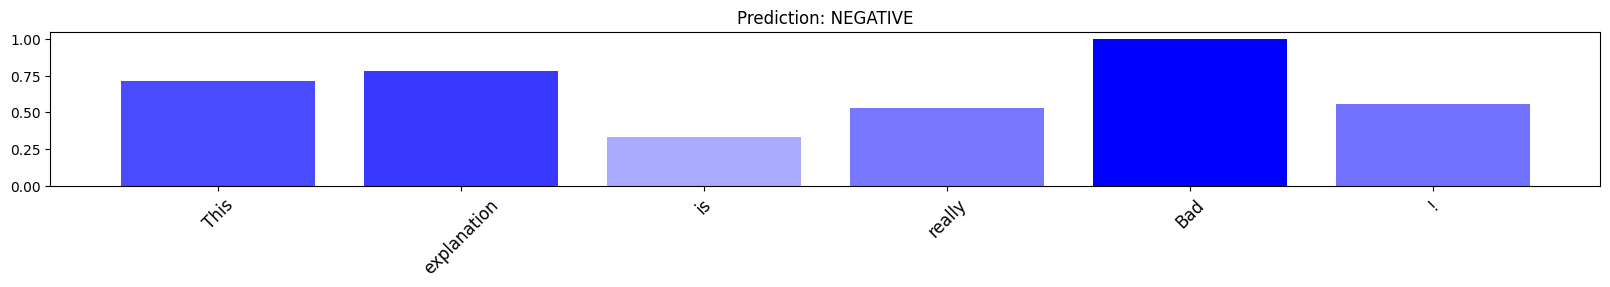

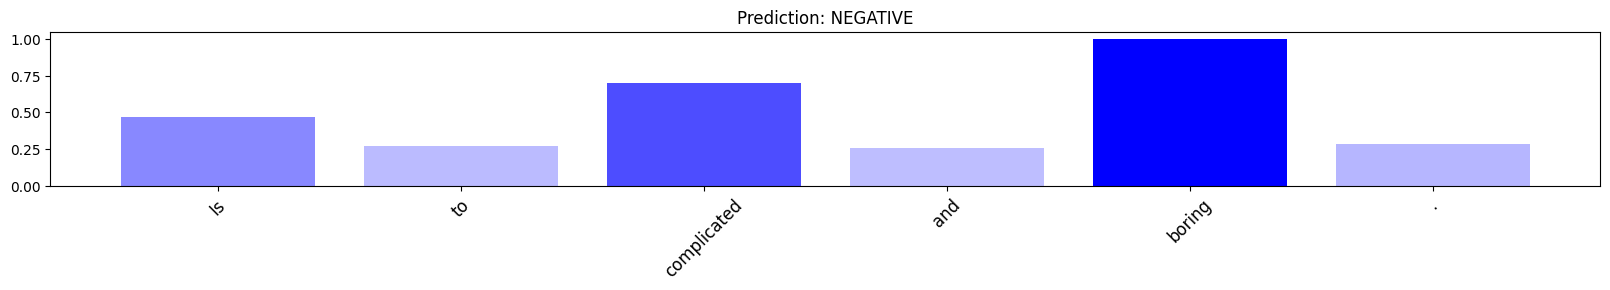

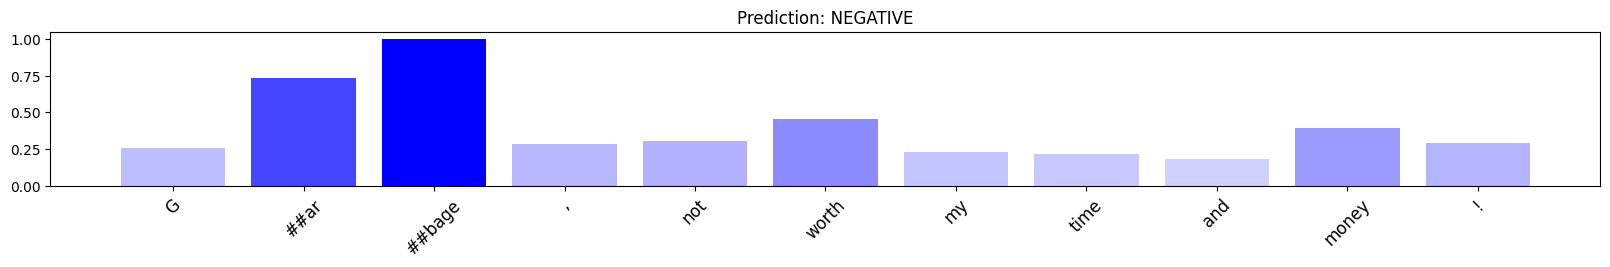

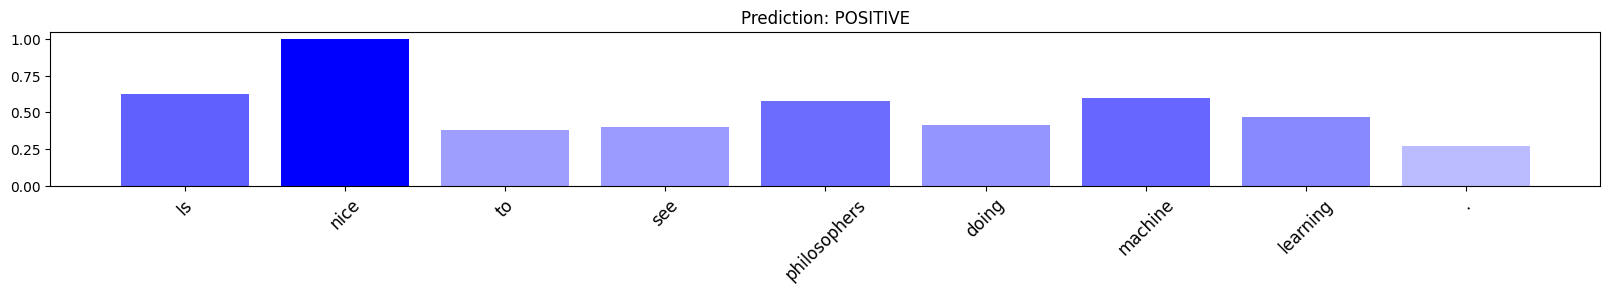

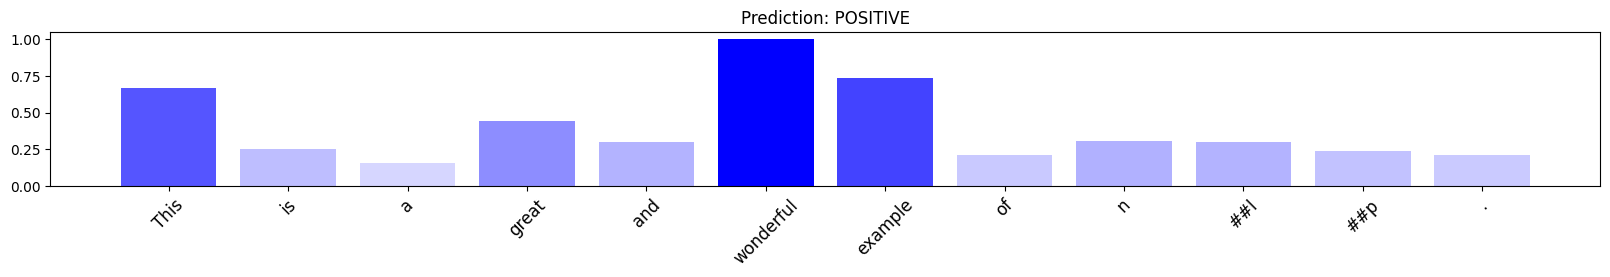

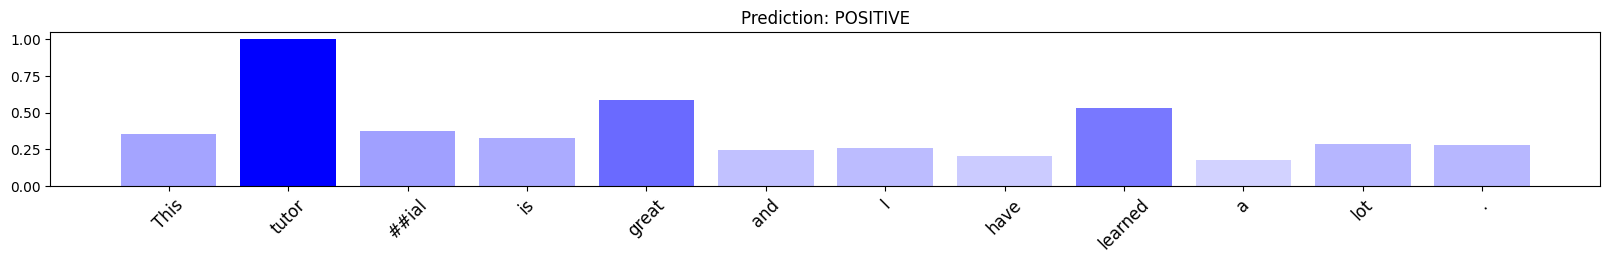

In [80]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from IPython.display import HTML

def plot_gradient_scores(text, words, gradients, prediction_class):
    """
    Plot the gradient scores for each word in the input text.

    Args:
        text (str): The input text for which gradients need to be computed.
        words (list): A list of tokens corresponding to the input text.
        gradients (list): A list of gradient values, each corresponding to a
            token in the sequence.
        prediction_label (str): The predicted label for the input text.

    Returns:
        None : the function plots a figure instead
    """

    # Remove special tokens [CLS] and [SEP]
    words = words[1:-1]
    gradients = gradients[1:-1]

    # Get min and max gradients
    minima = min(gradients)
    maxima = max(gradients)

    # Normalize gradients to between 0 and 1
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.YlOrRd)

    # Get colors corresponding to gradients
    colors = [mcolors.to_hex(mapper.to_rgba(v)) for v in gradients]

    # Create html string with the words colored corresponding to their gradients
    text_with_gradients = ' '.join([f'''<span style="color:{colors[i]}"><b>{words[i]}</b></span>''' for i in range(len(words))])
    display(HTML(f"<b>Text</b>: <i>{text}</i>"))
    display(HTML(f"<b>Integrated Gradient Scores:</b> {text_with_gradients}"))

    # Plot the gradients on a bar chart
    plt.figure(figsize=(20,2))
    xvals = [ x + str(i) for i,x in enumerate(words)]
    colors =  [ (0,0,1, c) for c in (gradients) ]
    plt.tick_params(axis='both', which='minor', labelsize=29)
    plt.title(f"Prediction: {model.config.id2label[int(prediction_class)]}")
    plt.bar(xvals, gradients, color=colors, linewidth=1 )
    plt.xticks(ticks=[i for i in range(len(words))], labels=words, fontsize=12,rotation=45)
    plt.show()

texts = [
    'This explanation is really Bad!',
    'Is to complicated and boring.',
    'Garbage, not worth my time and money!',
    'Is nice to see philosophers doing machine learning.',
    'This is a great and wonderful example of nlp.',
    'This tutorial is great and I have learned a lot.'
]


for text in texts:
    gradient_tensor, token_words, prediction_class = get_gradients(text, model, tokenizer)
    plot_gradient_scores(text, token_words, gradient_tensor, prediction_class)

Awesome! We learned how to interpret the outputs of our text classifier via the integrated gradients technique. Now, let us apply this to a simple interpretability app.

We have a demo app of the following URL that employs this explainability technique.

- Visit our [Integrated-gradients-DistilBERT](https://huggingface.co/spaces/nicholasKluge/Integrated-gradients-DistilBERT?logs=build) Space! 🤗

> **Note:** In it, we are using  [Gradio](https://gradio.app/) to construct the interface. You can learn more on how to build these apps in [this tutorial](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Intro-Course/19_quick_AI_app.ipynb), and [Gradio's documentaion](https://www.gradio.app/docs/interface).

By applying `Integrated Gradients`, we can gain valuable insights into the inner workings of machine learning models and improve trust, interpretability, and understanding in AI systems, promoting accountability and ethical considerations in these applications.

---

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).